In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Imports

In [3]:
import pyspark
from ifood_case.feature_engineering import FeatureEngineering
from ifood_case.model_trainer import LGBMTrainer
from ifood_case.evaluator import Evaluator
from ifood_case.utils import find_optimal_threshold
import pyspark.sql.functions as F
import warnings

In [4]:
warnings.filterwarnings('ignore')

## Initialize Spark

In [5]:
spark = pyspark.sql.SparkSession.builder.appName("ifood-case").getOrCreate()

25/09/25 14:17:32 WARN Utils: Your hostname, solid resolves to a loopback address: 127.0.0.2; using 192.168.0.39 instead (on interface enp5s0)
25/09/25 14:17:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/25 14:17:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Variables

In [6]:
OFFER_COST = 0.50 # Custo para enviar uma oferta para alguém. Sintético e simbólico

## Load Data

In [7]:
offers = spark.read.parquet("../data/processed/offers_processed")
transactions = spark.read.parquet("../data/processed/transactions_processed")
profile = spark.read.parquet("../data/processed/profile_processed")

## Modelling

### Feature Engieneering

In [8]:
fe = FeatureEngineering(offers, transactions, profile)

In [9]:
df, numerical_columns, categorical_columns = fe.transform()

Column account_id is string or is in exclude list: ['account_id', 'offer_id', 'time_received', 'target']
Column offer_id is string or is in exclude list: ['account_id', 'offer_id', 'time_received', 'target']
Column time_received is double or is in exclude list: ['account_id', 'offer_id', 'time_received', 'target']
Column target is int or is in exclude list: ['account_id', 'offer_id', 'time_received', 'target']


In [10]:
df.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- offer_id: string (nullable = true)
 |-- time_received: double (nullable = true)
 |-- target: integer (nullable = false)
 |-- total_spend_before: double (nullable = true)
 |-- transaction_count_before: long (nullable = true)
 |-- avg_ticket_before: double (nullable = true)
 |-- max_ticket_before: double (nullable = true)
 |-- min_ticket_before: double (nullable = true)
 |-- offers_viewed_count_before: long (nullable = true)
 |-- offers_completed_count_before: long (nullable = true)
 |-- customer_conversion_rate_before: double (nullable = true)
 |-- last_offer_viewed_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)
 |-- dayofweek_sin: double (nullable = true)
 |-- dayofweek_cos: double (nullable = true)
 |-- discount_value: long (nullable = true)
 |-- dura

### Model Train

In [13]:
lgbm_trainer = LGBMTrainer(df, numerical_columns, categorical_columns, "target")

In [14]:
x_train, x_test, y_train, y_test = lgbm_trainer.train()

### Model Evaluate

In [15]:
evaluator = Evaluator(x_test, y_test)

In [16]:
y_pred = lgbm_trainer.predict(x_test)

In [17]:
y_pred_proba = lgbm_trainer.predict_proba(x_test)

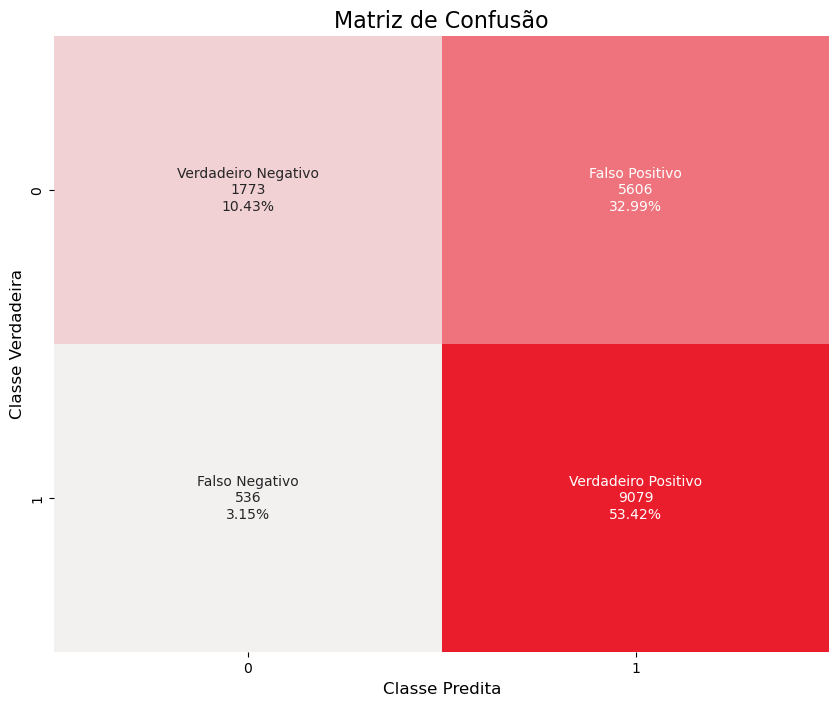

In [18]:
metrics = evaluator.report(y_pred, y_pred_proba)

In [19]:
metrics.keys()

dict_keys(['roc_auc', 'pr_auc', 'taxa_conversao_real_teste', 'taxa_conversao_modelo', 'classification_report'])

In [20]:
metrics["roc_auc"]

0.67

In [21]:
metrics["pr_auc"]

0.69

In [22]:
metrics["taxa_conversao_real_teste"]

np.float64(56.58)

In [23]:
metrics["taxa_conversao_modelo"]

np.float64(86.41)

In [24]:
metrics["classification_report"]

{'0': {'precision': 0.77, 'recall': 0.24, 'f1-score': 0.37, 'support': 7379.0},
 '1': {'precision': 0.62, 'recall': 0.94, 'f1-score': 0.75, 'support': 9615.0},
 'accuracy': 0.64,
 'macro avg': {'precision': 0.69,
  'recall': 0.59,
  'f1-score': 0.56,
  'support': 16994.0},
 'weighted avg': {'precision': 0.68,
  'recall': 0.64,
  'f1-score': 0.58,
  'support': 16994.0}}

#### UP Lift

In [25]:
avg_conversion_value = x_train.loc[y_train == 1,:]['max_ticket_before'].mean()

In [26]:
results_df = find_optimal_threshold(evaluator, y_pred_proba, avg_conversion_value, OFFER_COST)

Análise de Threshold vs. Uplift:
    threshold  model_profit    uplift
0        0.05     193126.74    4808.0
1        0.10     193126.74    4808.0
2        0.15     190864.12    2545.0
3        0.20     190864.12    2545.0
4        0.25     189626.68    1307.0
5        0.30     188119.22    -200.0
6        0.35     188119.22    -200.0
7        0.40     188119.22    -200.0
8        0.45     186346.42   -1973.0
9        0.50     183041.48   -5278.0
10       0.55     159670.89  -28648.0
11       0.60     121991.81  -66327.0
12       0.65     103162.72  -85157.0
13       0.70      74171.25 -114148.0
14       0.75      65959.02 -122360.0
15       0.80      13308.66 -175011.0
16       0.85          0.00 -188319.0
17       0.90          0.00 -188319.0
18       0.95          0.00 -188319.0

--- Melhor Threshold Encontrado ---
threshold            0.05
model_profit    193126.74
uplift            4808.00
Name: 0, dtype: float64
